In [1]:
import time

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from PIL import Image
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVPerspectiveCameras, look_at_view_transform
import torchvision.transforms as transforms

to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

/home/jorge/miniconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0")
device = torch.device('cpu')
mesh_og = load_objs_as_meshes(['../data/cow_mesh/cow.obj'], device=device)

mesh = mesh_og
V = mesh.num_verts_per_mesh()[0].item()
F = mesh.num_faces_per_mesh()[0].item()

In [3]:
R, T = look_at_view_transform(dist=2, azim=150, elev=0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60).cpu()

In [4]:
from rendering import rasterize

res = 256
fragments, depth_map = rasterize(cameras, mesh, res)

In [5]:
image = Image.open('../data/example/view.png').resize((res, res))
feature_tensor = to_tensor(image).permute(1, 2, 0)

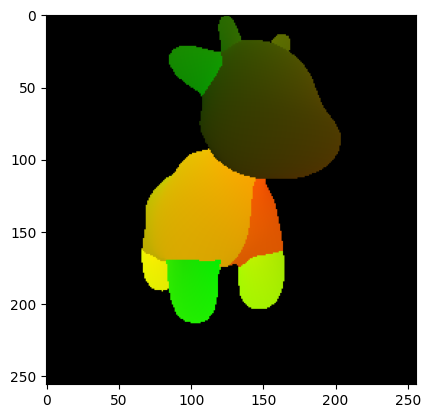

In [7]:
from einops import rearrange
from pytorch3d.ops import interpolate_face_attributes
from pytorch3d.renderer import TexturesUV

texture: TexturesUV = mesh.textures

verts = mesh.verts_list()[0]

texture_map = texture.maps_list()[0]
vert_uvs = texture.verts_uvs_list()[0]
face_uvs = texture.faces_uvs_list()[0]
face_vert_uvs = vert_uvs[face_uvs]

fragments, _ = rasterize(cameras, mesh, res)

# interpolate with barycentric coords
pixel_uvs = interpolate_face_attributes(
    fragments.pix_to_face,
    fragments.bary_coords,
    face_vert_uvs
)
pixel_uvs = rearrange(pixel_uvs, '1 h w 1 d -> h w d')

pixel_uvs_rgb = torch.cat((pixel_uvs, torch.zeros(res, res, 1)), dim=-1)
plt.imshow(pixel_uvs_rgb)

In [106]:
mask = depth_map != -1

masked_uvs = pixel_uvs[mask]

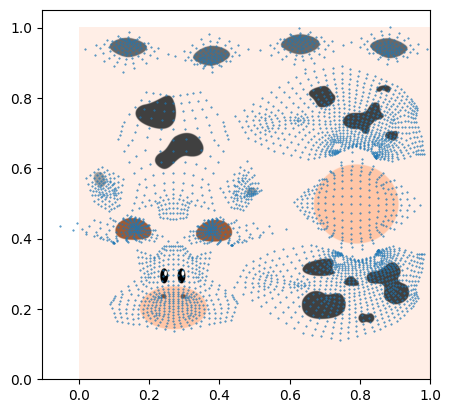

In [9]:
from rendering import EXTENT_UV

plt.imshow(texture_map, extent=EXTENT_UV)
plt.scatter(x=vert_uvs[:, 0], y=vert_uvs[:, 1], s=0.2)

In [100]:

import rerun as rr
import rerun_util as ru


rr.init('debug', spawn=True)
rr.log('/', rr.ViewCoordinates.LUF, static=True)
rr.log('/', rr.Transform3D())

rr.log('cam', ru.pt3d_FovCamera(cameras, 0, res=res))
cam_trans = cameras.get_world_to_view_transform().inverse()
rr.log('cam', ru.pt3d_transform(cam_trans))
rr.log('cam', rr.Image(depth_map.cpu().numpy()))

# log mesh
# rr.log("mesh", ru.pt3d_mesh(mesh, vertex_colors=vertex_colors))


[2024-09-03T17:12:34Z INFO  re_sdk::spawn] A process is already listening at this address. Assuming it's a Rerun Viewer. addr=0.0.0.0:9876
